# PFCS data

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from data.PFCS.scripts.gt_plot import read_data
from pathlib import Path

# from sktime.clustering.dbscan import TimeSeriesDBSCAN
# from sklearn.metrics.pairwise import pairwise_distances
# from sklearn import metrics
# from sklearn.cluster import DBSCAN
from scipy import signal

In [2]:
# %matplotlib ipympl

## Get data + preprocessing

In [3]:
task_ground_truth = [
    {
        "filename": "fetch_recorded_demo_1730997119",
        "idx": {
            "plate": {"ini": 0, "end": 1125},
            "napkin": {"ini": 1125, "end": 2591},
            "cup": {"ini": 2591, "end": 3986},
            "fork": {"ini": 3986, "end": 5666},
            "spoon": {"ini": 5666, "end": 7338},
        },
    },
    {
        "filename": "fetch_recorded_demo_1730997530",
        "idx": {
            "plate": {"ini": 0, "end": 1812},
            "napkin": {"ini": 1812, "end": 3844},
            "cup": {"ini": 3844, "end": 5732},
            "fork": {"ini": 5732, "end": 7090},
            "spoon": {"ini": 7090, "end": 7955},
        },
    },
    {
        "filename": "fetch_recorded_demo_1730997735",
        "idx": {
            "plate": {"ini": 0, "end": 1965},
            "napkin": {"ini": 1965, "end": 4178},
            "cup": {"ini": 4178, "end": 6427},
            "spoon": {"ini": 6427, "end": 7904},
            "fork": {"ini": 7904, "end": 9123},
        },
    },
    {
        "filename": "fetch_recorded_demo_1730997956",
        "idx": {
            "plate": {"ini": 0, "end": 1898},
            "napkin": {"ini": 1898, "end": 4081},
            "cup": {"ini": 4081, "end": 5442},
            "spoon": {"ini": 5442, "end": 6829},
            "fork": {"ini": 6829, "end": 9177},
        },
    },
]

In [4]:
filenum = 0
datapath_root = Path("./data/PFCS/table task")


def data2df(task_ground_truth, filenum, datapath_root, timestamps=True):
    xyz_path = (
        datapath_root
        / "xyz data"
        / "full_tasks"
        / (task_ground_truth[filenum]["filename"] + ".txt")
    )
    h5_path = (
        datapath_root / "h5 files" / (task_ground_truth[filenum]["filename"] + ".h5")
    )

    data = np.loadtxt(xyz_path)  # load the file into an array
    joint_data, tf_data, gripper_data = read_data(h5_path)

    if timestamps:
        time_sec = tf_data[0][:, 0]
        time_nanosec = tf_data[0][:, 1]
        timestamps = []
        for t_idx, t_val in enumerate(time_sec):
            timestamp = pd.Timestamp(
                time_sec[t_idx], unit="s", tz="EST"
            ) + pd.to_timedelta(time_nanosec[t_idx], unit="ns")
            timestamps.append(timestamp)
        timestamps = pd.Series(timestamps)

        traj = pd.DataFrame(
            {
                "x": data[:, 0],
                "y": data[:, 1],
                "z": data[:, 2],
                "timestamps": timestamps,
            }
        )
    else:
        traj = pd.DataFrame({"x": data[:, 0], "y": data[:, 1], "z": data[:, 2]})
    return traj

In [5]:
traj = data2df(
    task_ground_truth=task_ground_truth, filenum=filenum, datapath_root=datapath_root
)
traj

,x,y,z,timestamps
0,0.425767,0.243364,0.976381,2024-11-07 11:31:59.503861904-05:00
1,0.425373,0.243382,0.976542,2024-11-07 11:31:59.533841848-05:00
2,0.425282,0.243515,0.976639,2024-11-07 11:31:59.553872347-05:00
3,0.425282,0.243515,0.976639,2024-11-07 11:31:59.553872347-05:00
4,0.425350,0.243331,0.976105,2024-11-07 11:31:59.583873749-05:00
...,...,...,...,...
7333,0.662908,0.221483,1.031193,2024-11-07 11:34:42.413918734-05:00
7334,0.662635,0.221682,1.031233,2024-11-07 11:34:42.443821907-05:00
7335,0.662784,0.222090,1.030785,2024-11-07 11:34:42.473963261-05:00
7336,0.662740,0.221329,1.030948,2024-11-07 11:34:42.503791571-05:00


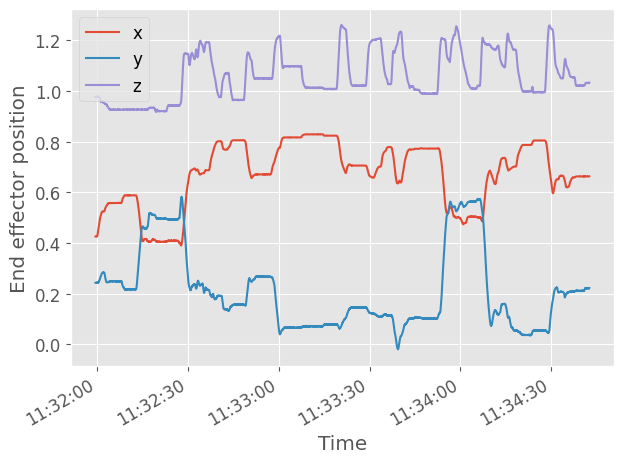

In [6]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamps, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamps, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamps, traj.z, label="z")  # , color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [7]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#     fig.suptitle("End effector position")
#     ax.plot(traj.x, traj.y, traj.z)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
#     plt.show()

## Ground truth segmentation

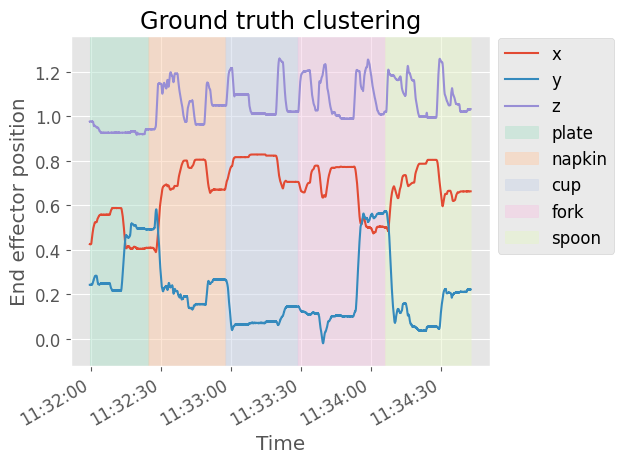

In [8]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.timestamps, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamps, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamps, traj.z, label="z")  # , color=cmap[2])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max()])
    for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
        sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
        x = traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]]
        ax.fill_between(
            x=x,
            y1=fill_min,
            y2=fill_max,
            color=cmap[sect_i],
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

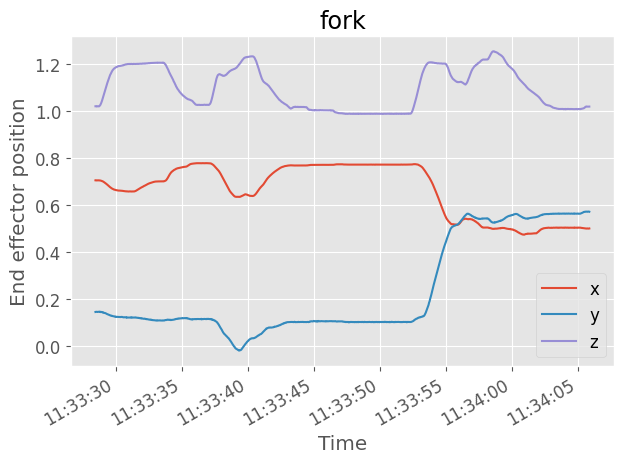

In [9]:
sect_key = "fork"
sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]

with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(
        traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.x[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="x",
    )  # , color=cmap[0])
    ax.plot(
        traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.y[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="y",
    )  # , color=cmap[1])
    ax.plot(
        traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.z[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="z",
    )  # , color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    ax.set_title(sect_key)
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [10]:
traj.z[sect_dict_current["ini"] : sect_dict_current["end"]]

3986    1.020806
3987    1.020688
3988    1.020904
3989    1.019882
3990    1.019882
          ...   
5661    1.019099
5662    1.019349
5663    1.019303
5664    1.019392
5665    1.019392
Name: z, Length: 1680, dtype: float64

In [11]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     cmap = mpl.colormaps.get("tab10").colors
#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#     fig.suptitle("End effector position")

#     for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
#         sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
#         ax.plot(
#             traj.x[sect_dict_current["ini"] : sect_dict_current["end"]],
#             traj.y[sect_dict_current["ini"] : sect_dict_current["end"]],
#             traj.z[sect_dict_current["ini"] : sect_dict_current["end"]],
#             color=cmap[sect_i],
#             label=sect_key,
#         )
#     ax.legend(loc="best")
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
#     fig.tight_layout()
#     plt.show()

## Extract frequency

In [12]:
dt = np.mean(np.diff(traj.timestamps))
dt

Timedelta('0 days 00:00:00.022218888')

In [13]:
freq = np.round(1 / dt.total_seconds())
freq

np.float64(45.0)

## Export timeseries to plain text files

In [14]:
datapath = datapath_root / "export"
datapath

PosixPath('data/PFCS/table task/export')

In [15]:
if not datapath.exists():
    datapath.mkdir(parents=True)

In [16]:
downsampling_factor = 1
for idx, demo in enumerate(task_ground_truth):
    traj = data2df(
        task_ground_truth=task_ground_truth,
        filenum=idx,
        datapath_root=datapath_root,
        timestamps=False,
    )
    if downsampling_factor > 1:
        traj_down = None
        for col in traj.columns:
            if traj_down is None:
                traj_down = signal.decimate(traj[col], q=downsampling_factor).T[
                    :, np.newaxis
                ]
            else:
                traj_down = np.concatenate(
                    [
                        traj_down,
                        signal.decimate(traj[col], q=downsampling_factor).T[
                            :, np.newaxis
                        ],
                    ],
                    axis=1,
                )
        np.savetxt(datapath.joinpath(f"{demo['filename']}_{idx}.txt"), traj_down)
    else:
        np.savetxt(datapath.joinpath(f"{demo['filename']}_{idx}.txt"), traj)